# Prediction of Crop Type Based on Environmental and Soil Conditions Using Pyspark 

# Environment Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time


from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")


# Data Loading

In [3]:
# Initialize SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CropPrediction").getOrCreate()

# Load dataset
sInputPath = "indiancrop_dataset.csv"
df = spark.read.csv(sInputPath, header=True, inferSchema=True)

df.printSchema()
print(f"\nNo of Rows: {df.count()}, \nNo of Columns: {len(df.columns)}\n")


df.describe().show() #show(vertical=True)
pd.DataFrame(df.take(5), columns=df.columns).transpose()

root
 |-- N_SOIL: integer (nullable = true)
 |-- P_SOIL: integer (nullable = true)
 |-- K_SOIL: integer (nullable = true)
 |-- TEMPERATURE: double (nullable = true)
 |-- HUMIDITY: double (nullable = true)
 |-- ph: double (nullable = true)
 |-- RAINFALL: double (nullable = true)
 |-- STATE: string (nullable = true)
 |-- CROP_PRICE: integer (nullable = true)
 |-- CROP: string (nullable = true)


No of Rows: 2200, 
No of Columns: 10

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+----------+
|summary|            N_SOIL|           P_SOIL|            K_SOIL|       TEMPERATURE|          HUMIDITY|                ph|          RAINFALL|              STATE|       CROP_PRICE|      CROP|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+----

0                    1                    2  \
N_SOIL                        90                   85                   60   
P_SOIL                        42                   58                   55   
K_SOIL                        43                   41                   44   
TEMPERATURE            20.879744            21.770462            23.004459   
HUMIDITY               82.002744            80.319644            82.320763   
ph                      6.502985             7.038096             7.840207   
RAINFALL              202.935536           226.655537           263.964248   
STATE        Andaman and Nicobar  Andaman and Nicobar  Andaman and Nicobar   
CROP_PRICE                  7000                 5000                 7000   
CROP                        Rice                 Rice                 Rice   

                               3                    4  
N_SOIL                        74                   78  
P_SOIL                        35                   42  
K_SOIL                        40                   42  
TEMPERATURE            26.491096            20.130175  
HUMIDITY               80.158363            81.604873  
ph                      6.980401             7.628473  
RAINFALL              242.864034            262.71734  
STATE        Andaman and Nicobar  Andaman and Nicobar  
CROP_PRICE                  7000               120000  
CROP                        Rice                 Rice

In [3]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

0                   1                   2    3       4
summary     count                mean              stddev  min     max
N_SOIL       2200  50.551818181818184  36.917333833756594    0     140
P_SOIL       2200   53.36272727272727   32.98588273858713    5     145
K_SOIL       2200   48.14909090909091  50.647930546660135    5     205
CROP_PRICE   2200   2689.228181818182   3710.361266543198    2  120000

# Check Dataset Balance

In [4]:
df.groupby('CROP').count().toPandas()

CROP  count
0        Papaya    100
1    PigeonPeas    100
2        Orange    100
3      ChickPea    100
4        Banana    100
5         Maize    100
6     Muskmelon    100
7       Coconut    100
8     MothBeans    100
9     Blackgram    100
10  KidneyBeans    100
11       Grapes    100
12         Jute    100
13       Coffee    100
14        Mango    100
15       Cotton    100
16         Rice    100
17   Watermelon    100
18     MungBean    100
19  Pomegranate    100
20        Apple    100
21       Lentil    100

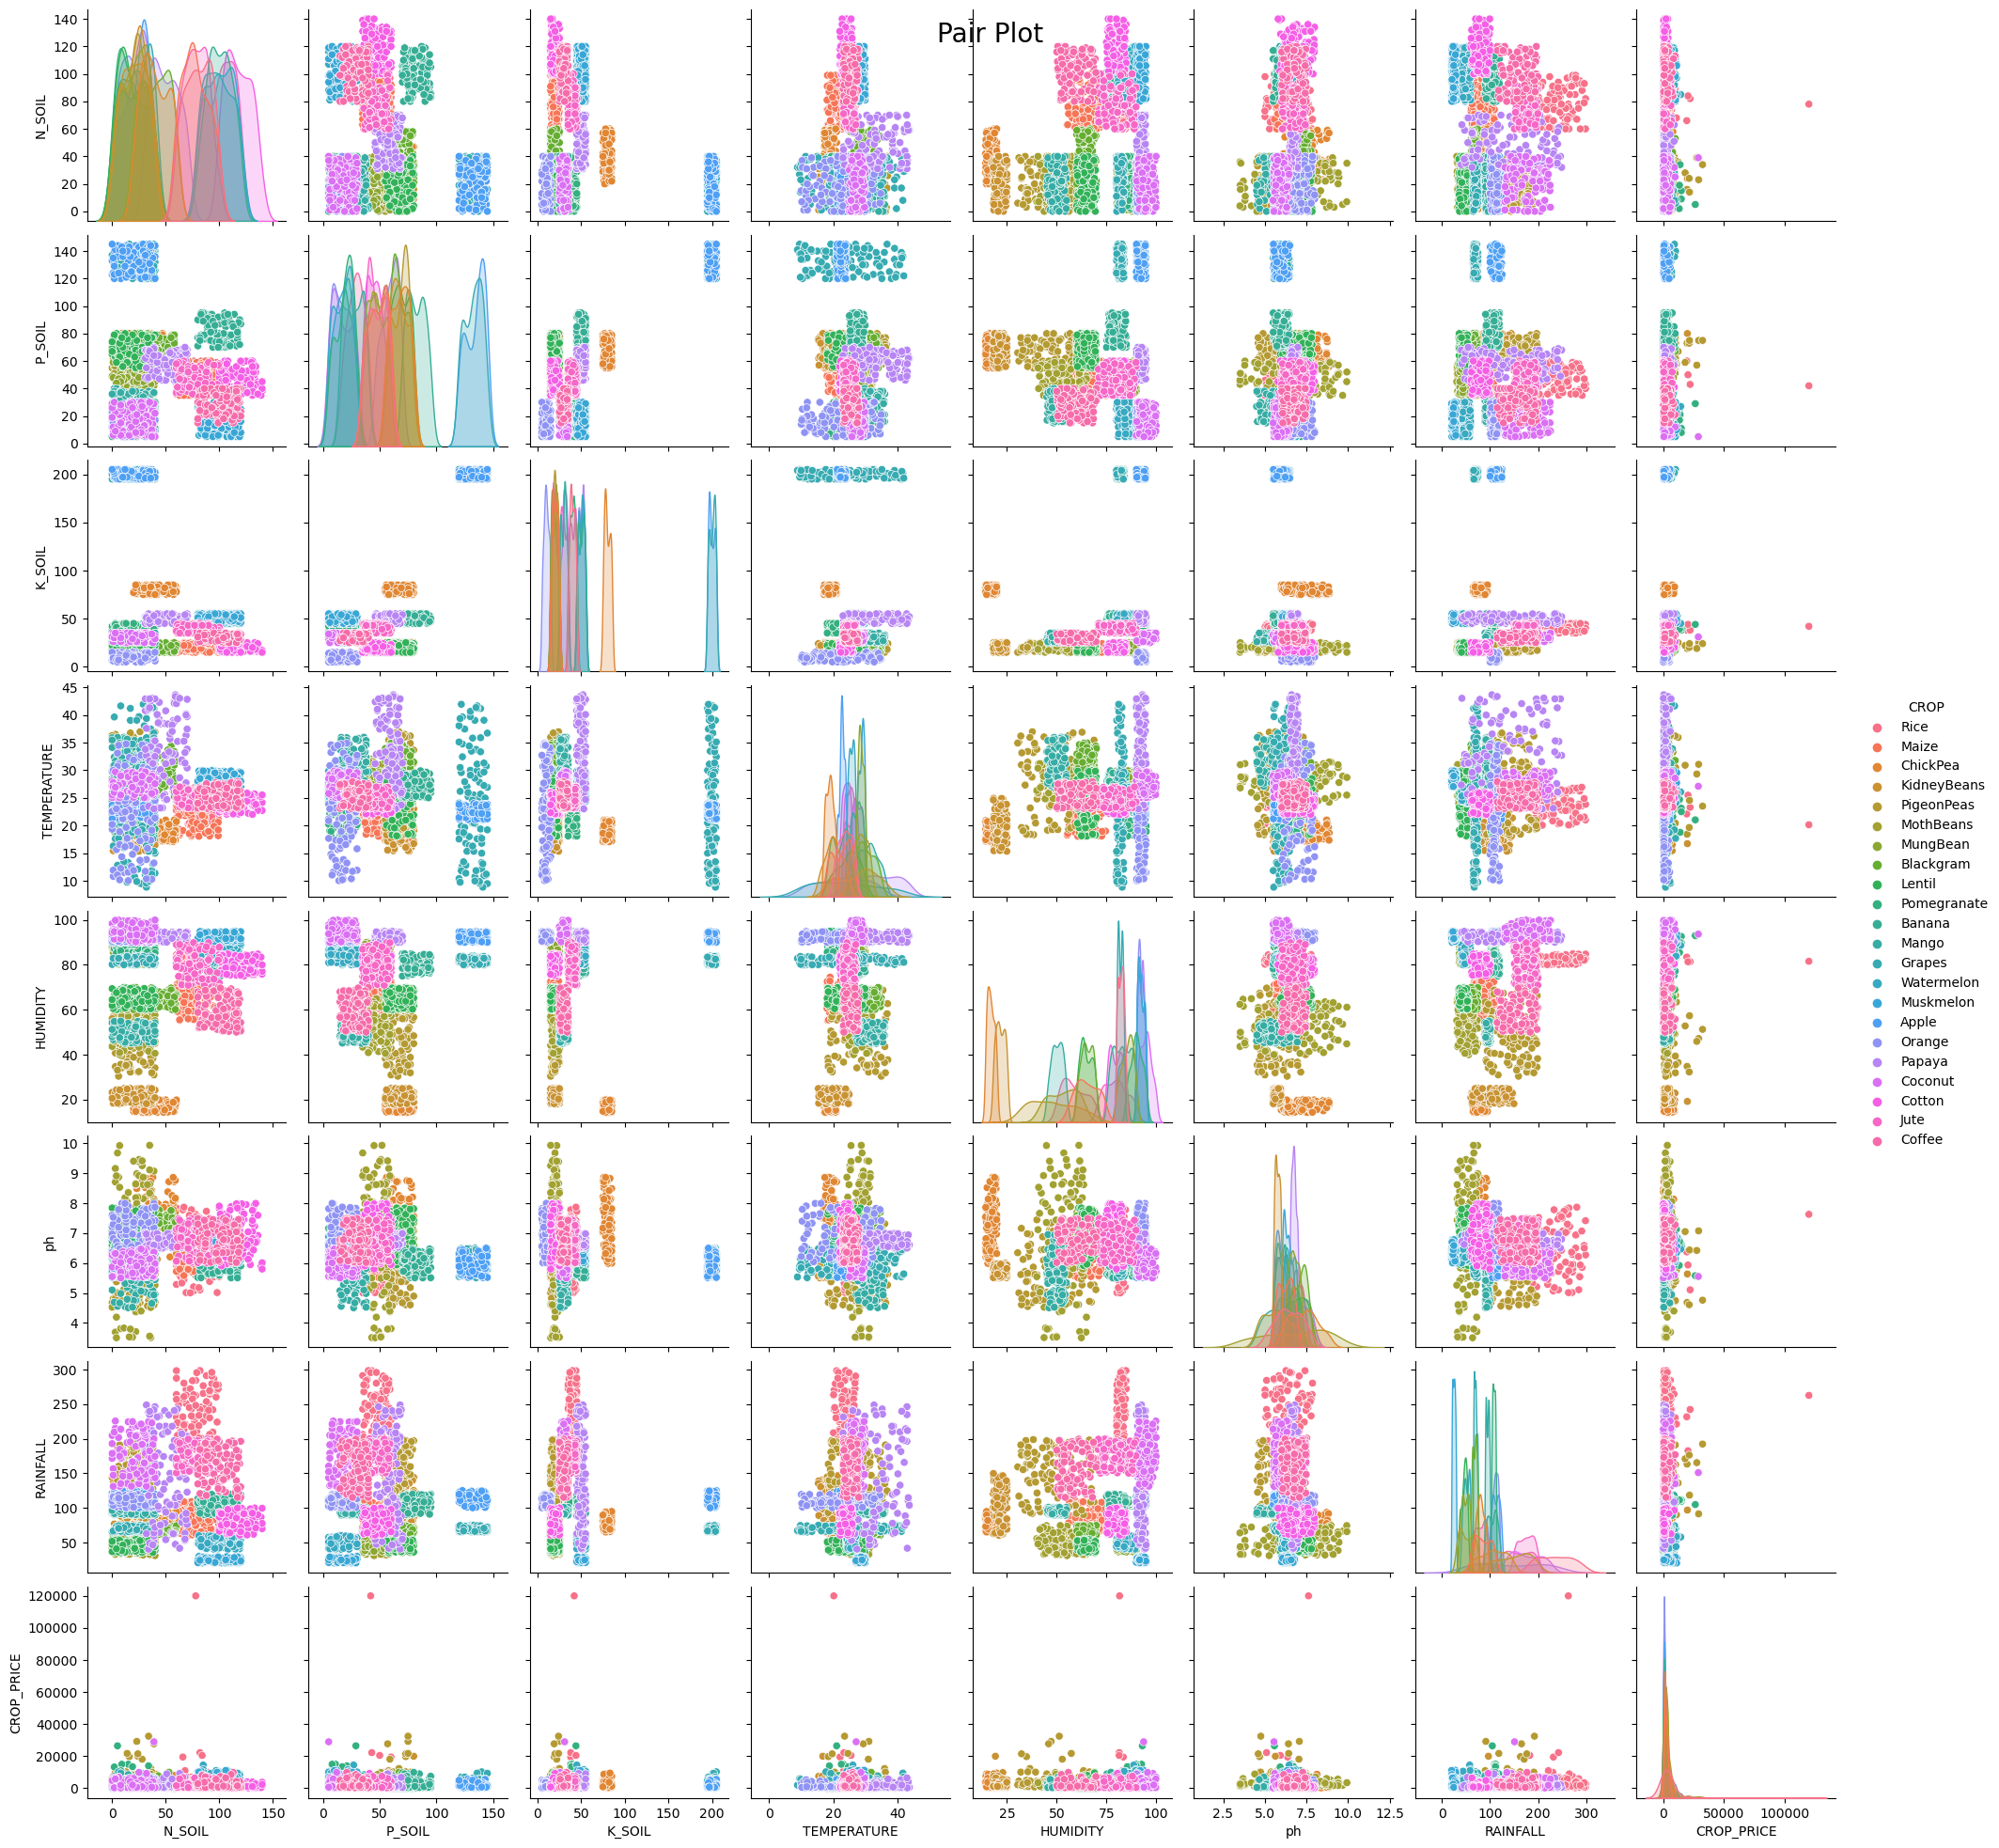

In [5]:
# Pair Plot
pandas_df = df.limit(2200).toPandas()
# Generating pair plot
sns.pairplot(pandas_df, hue='CROP')
plt.suptitle('Pair Plot', size=20)
plt.show()
plt.close()


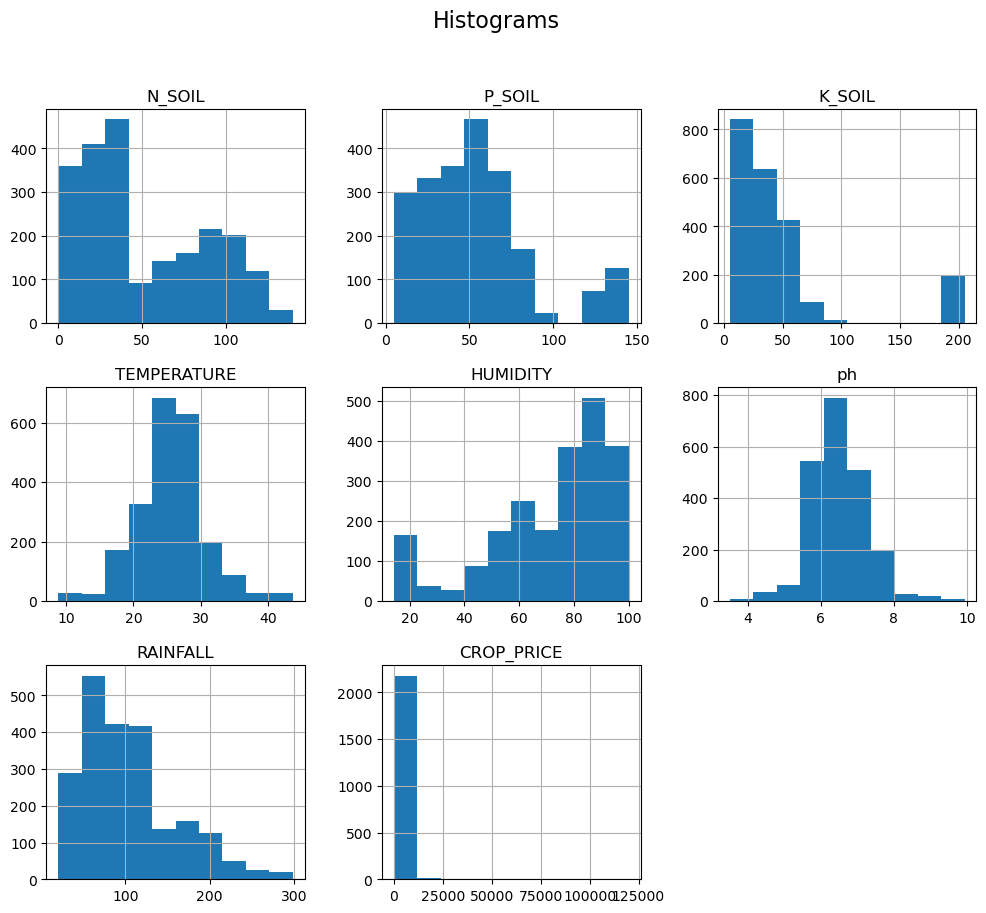

In [6]:
# Generating histograms for each feature
pandas_df.hist(figsize=(12,10))
plt.suptitle('Histograms', size=16)
plt.show()
plt.close()

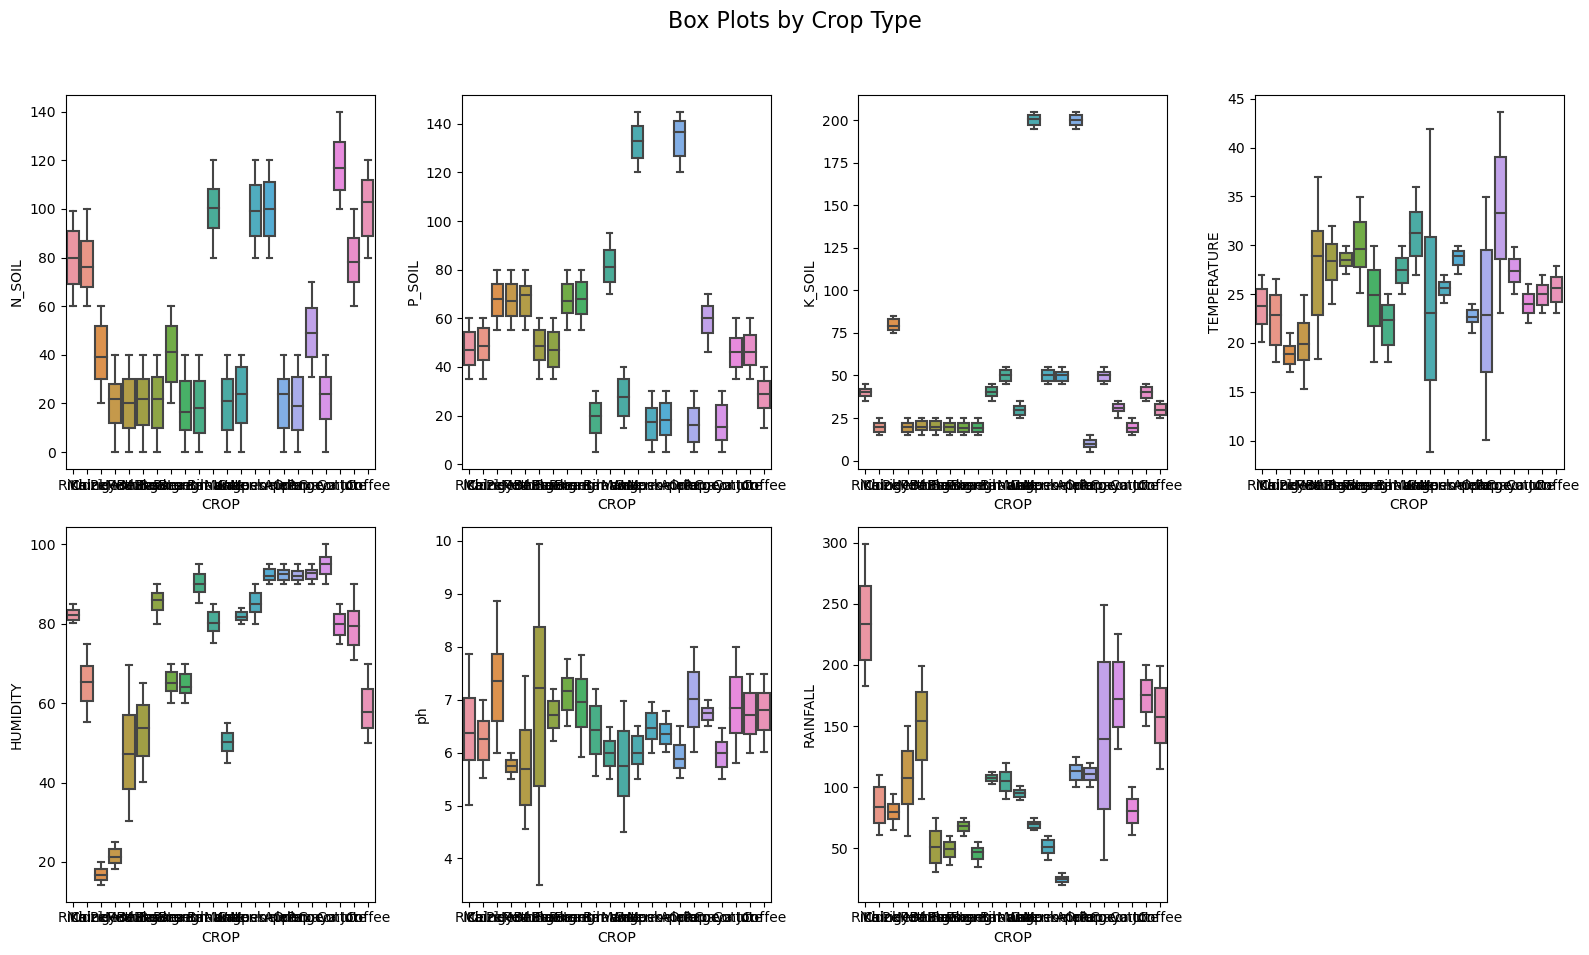

In [7]:
# Box plots
# Select only the columns of interest for box plots
columns_of_interest = ['N_SOIL', 'P_SOIL', 'K_SOIL', 'TEMPERATURE', 'HUMIDITY', 'ph', 'RAINFALL']
numeric_columns = [col for col in columns_of_interest if col in pandas_df.columns]

# Determine the number of rows/columns needed for the subplot grid
n_cols = 4
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Round up to ensure enough subplots

# Create the subplot grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10), squeeze=False)  # Ensure axes is always 2D
for i, column in enumerate(numeric_columns):
    sns.boxplot(data=pandas_df, x='CROP', y=column, ax=axes[i//n_cols, i%n_cols])
    
# Hide any empty subplots if the number of numeric_columns isn't a multiple of n_cols
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j//n_cols, j%n_cols])

plt.suptitle('Box Plots by Crop Type', size=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# plt.close()

# scatterplot

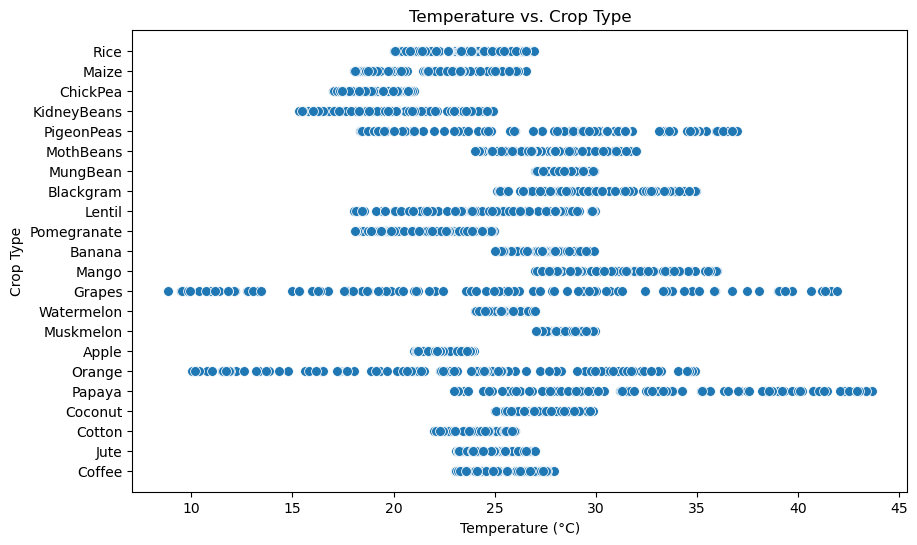

In [8]:
# Selecting specific columns for analysis
selected_df = df.select("TEMPERATURE", "CROP", "N_SOIL", "P_SOIL", "K_SOIL")
plot_data = selected_df.toPandas()

# Temperature vs. Crop Type plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='TEMPERATURE', y='CROP', palette='viridis', s=50)
plt.title('Temperature vs. Crop Type')
plt.xlabel('Temperature (°C)')
plt.ylabel('Crop Type')
plt.show()
plt.close()

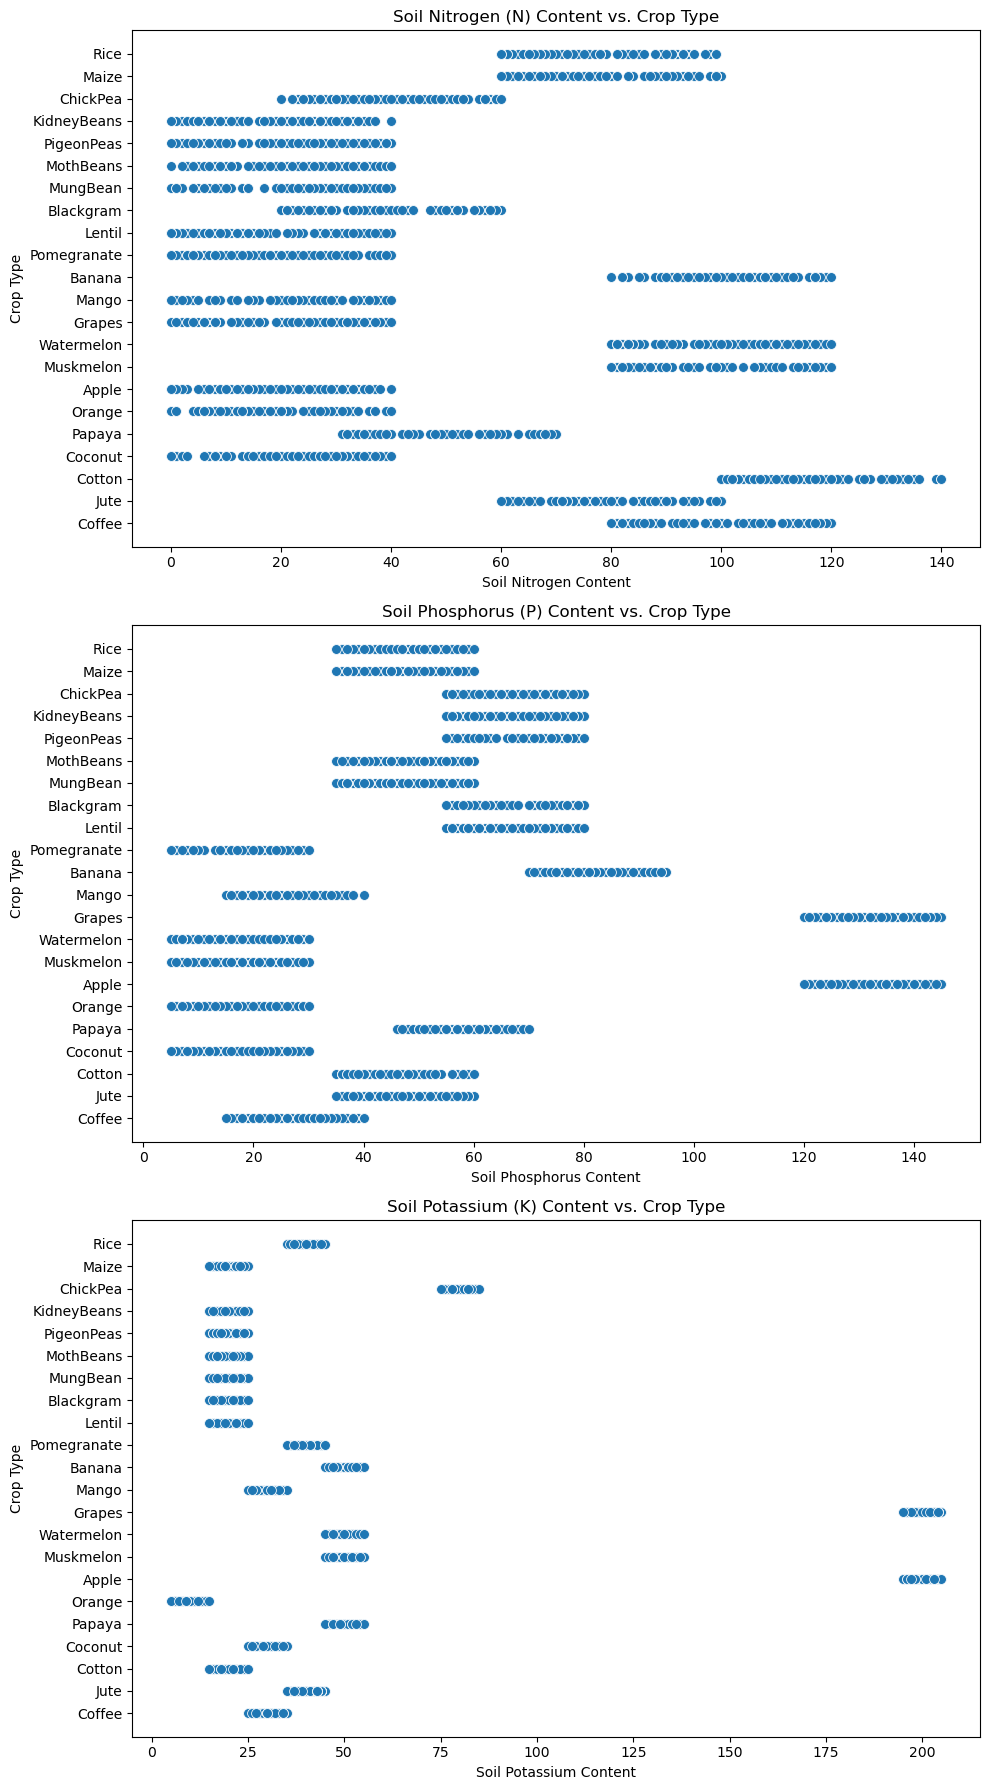

In [9]:

# Create subplots for Soil N, P, K vs. Crop Type
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Soil N (Nitrogen) vs. Crop Type
sns.scatterplot(ax=axes[0], data=plot_data, x='N_SOIL', y='CROP', palette='viridis', s=50)
axes[0].set_title('Soil Nitrogen (N) Content vs. Crop Type')
axes[0].set_xlabel('Soil Nitrogen Content')
axes[0].set_ylabel('Crop Type')

# Soil P (Phosphorus) vs. Crop Type
sns.scatterplot(ax=axes[1], data=plot_data, x='P_SOIL', y='CROP', palette='viridis', s=50)
axes[1].set_title('Soil Phosphorus (P) Content vs. Crop Type')
axes[1].set_xlabel('Soil Phosphorus Content')
axes[1].set_ylabel('Crop Type')

# Soil K (Potassium) vs. Crop Type
sns.scatterplot(ax=axes[2], data=plot_data, x='K_SOIL', y='CROP', palette='viridis', s=50)
axes[2].set_title('Soil Potassium (K) Content vs. Crop Type')
axes[2].set_xlabel('Soil Potassium Content')
axes[2].set_ylabel('Crop Type')

plt.tight_layout()
plt.show()
plt.close()

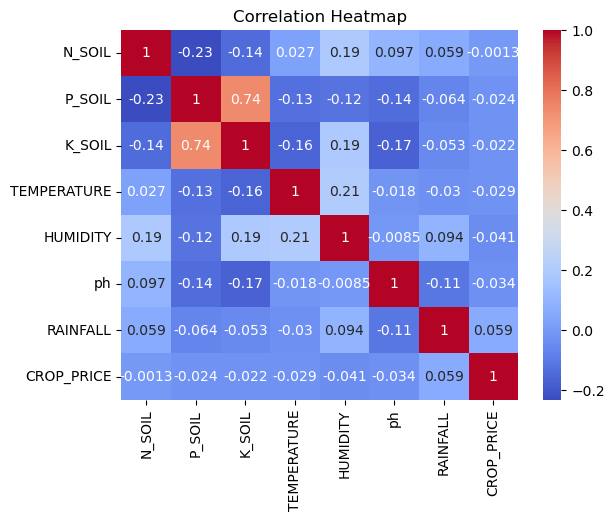

In [10]:
#Categorical Feature Encoding
# Select only the numeric columns for the correlation matrix
numeric_df = pandas_df.select_dtypes(include=[np.number])

# Generating correlation heatmap
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
plt.close()

In [14]:
# # calculating the correlation matrix for Tableau
# import pandas as pd
# import numpy as np

# # Load the dataset
# file_path = "indiancrop_dataset.csv"
# crop_data = pd.read_csv(file_path)
# crop_data_numeric_df = crop_data.select_dtypes(include=[np.number])

# # We'll use pandas to calculate the correlation matrix
# correlation_matrix_tableau = crop_data_numeric_df.corr()

# # Save the correlation matrix to a new CSV file for import into Tableau
# output_file_path = 'crop_data_correlation_matrix.csv'
# correlation_matrix_tableau.to_csv(output_file_path, index=True)

# correlation_matrix_tableau, output_file_path


(               N_SOIL    P_SOIL    K_SOIL  TEMPERATURE  HUMIDITY        ph  \
 N_SOIL       1.000000 -0.231460 -0.140512     0.026504  0.190688  0.096683   
 P_SOIL      -0.231460  1.000000  0.736232    -0.127541 -0.118734 -0.138019   
 K_SOIL      -0.140512  0.736232  1.000000    -0.160387  0.190859 -0.169503   
 TEMPERATURE  0.026504 -0.127541 -0.160387     1.000000  0.205320 -0.017795   
 HUMIDITY     0.190688 -0.118734  0.190859     0.205320  1.000000 -0.008483   
 ph           0.096683 -0.138019 -0.169503    -0.017795 -0.008483  1.000000   
 RAINFALL     0.059020 -0.063839 -0.053461    -0.030084  0.094423 -0.109069   
 CROP_PRICE  -0.001302 -0.023683 -0.021923    -0.029044 -0.041414 -0.033548   
 
              RAINFALL  CROP_PRICE  
 N_SOIL       0.059020   -0.001302  
 P_SOIL      -0.063839   -0.023683  
 K_SOIL      -0.053461   -0.021923  
 TEMPERATURE -0.030084   -0.029044  
 HUMIDITY     0.094423   -0.041414  
 ph          -0.109069   -0.033548  
 RAINFALL     1.000000    0.

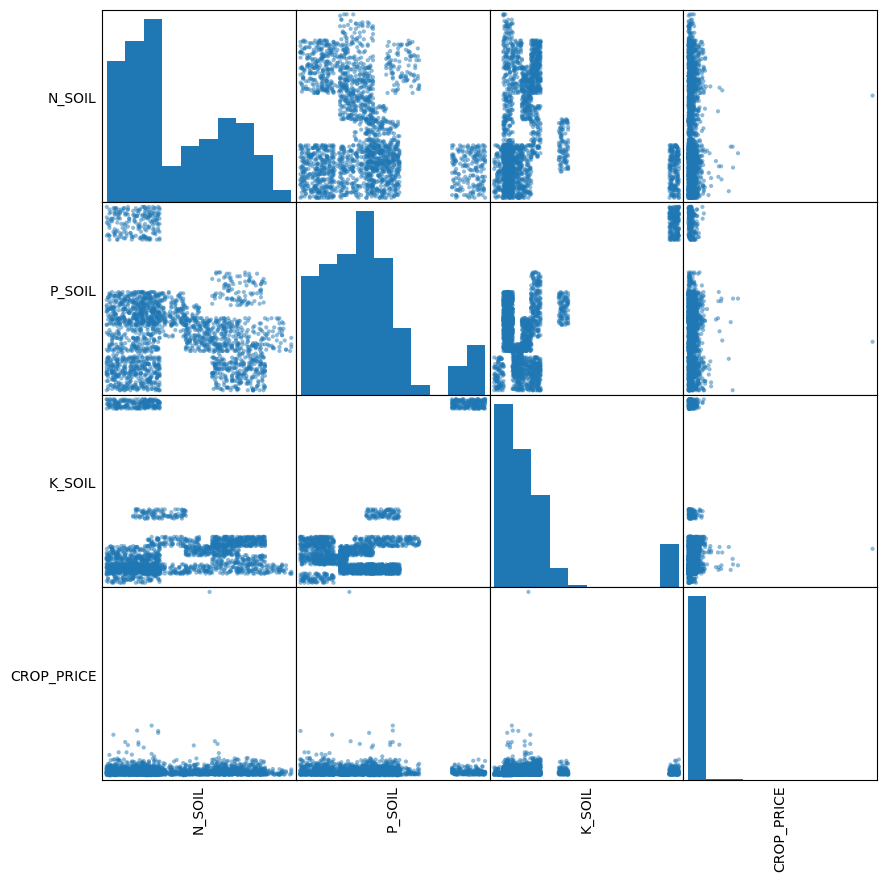

In [12]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(10, 10));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# Splitting the Dataset

In [13]:
# Indexing the categorical target column 'CROP'
labelIndexer = StringIndexer(inputCol="CROP", outputCol="label").fit(df)

# Assemble feature vectors
assembler = VectorAssembler(
    inputCols=["N_SOIL", "P_SOIL", "K_SOIL", "TEMPERATURE", "HUMIDITY", "ph", "RAINFALL"],
    outputCol="features")

# Split the data into training and test sets
(trainData, testData) = df.randomSplit([0.8, 0.2])


# Group and count the number of occurrences for each CROP type

In [16]:
# Full dataset
fullData_grouped = df.groupBy('CROP').count().withColumnRenamed('count', 'total_count')

# Training data
trainData_grouped = trainData.groupBy('CROP').count().withColumnRenamed('count', 'train_count')

# Test data
testData_grouped = testData.groupBy('CROP').count().withColumnRenamed('count', 'test_count')

# Join the training data counts with the full data counts
data_combined = fullData_grouped.join(trainData_grouped, 'CROP', 'outer')

# Join the combined data with the test data counts
data_combined = data_combined.join(testData_grouped, 'CROP', 'outer')

# Fill any missing counts with zero
data_combined = data_combined.na.fill(value=0)

# Order the results by CROP
data_combined = data_combined.orderBy('CROP')

display(HTML('<h1 style="color:blue;">After Split Count Comparisons</h1>'))

# Show the combined results
data_combined.show(n=data_combined.count(), truncate=False)


+-----------+-----------+-----------+----------+
|CROP       |total_count|train_count|test_count|
+-----------+-----------+-----------+----------+
|Apple      |100        |83         |17        |
|Banana     |100        |84         |16        |
|Blackgram  |100        |75         |25        |
|ChickPea   |100        |75         |25        |
|Coconut    |100        |86         |14        |
|Coffee     |100        |82         |18        |
|Cotton     |100        |78         |22        |
|Grapes     |100        |75         |25        |
|Jute       |100        |83         |17        |
|KidneyBeans|100        |82         |18        |
|Lentil     |100        |84         |16        |
|Maize      |100        |82         |18        |
|Mango      |100        |72         |28        |
|MothBeans  |100        |76         |24        |
|MungBean   |100        |80         |20        |
|Muskmelon  |100        |76         |24        |
|Orange     |100        |83         |17        |
|Papaya     |100    

# Classification Models Training and Prediction

In [20]:
def evaluate_and_show_results(cvPredictions, sTitle):
    """
    Evaluates the predictions from a classifier and displays various metrics.

    Parameters:
    - cvPredictions: DataFrame containing the predictions along with true labels.
    """

    # Initialize the evaluator with the true label and prediction columns
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    # Calculate and print the evaluation metrics
    accuracy = evaluator.evaluate(cvPredictions, {evaluator.metricName: "accuracy"})
    print(f"Test Accuracy = {accuracy:.4g}")

    f1 = evaluator.evaluate(cvPredictions, {evaluator.metricName: "f1"})
    print(f"Test F1 Score = {f1:.4g}")

    weightedPrecision = evaluator.evaluate(cvPredictions, {evaluator.metricName: "weightedPrecision"})
    print(f"Test Weighted Precision = {weightedPrecision:.4g}")

    weightedRecall = evaluator.evaluate(cvPredictions, {evaluator.metricName: "weightedRecall"})
    print(f"Test Weighted Recall = {weightedRecall:.4g}")

    

    return accuracy

    del evaluator
    del accuracy
    del f1
    del weightedPrecision
    del weightedRecall


In [21]:

def plot_confusion_matrix(cm_Predictions, plot_title):
    """
    Plots the confusion matrix for the Classification model.

    Parameters:
    - dt_Predictions: DataFrame containing the predictions from a Classification model.
    - plot_title: A string representing the title of the plot.
    """

    
    # Display the title in HTML format
    display(HTML(f'<div style="text-align:center;"><h1 style="color:blue;">{plot_title}</h1></div>'))

    # Convert predictions to RDD format and calculate the confusion matrix
    predictionAndLabels = cm_Predictions.select('label', 'prediction').rdd.map(tuple)
    metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = metrics.confusionMatrix().toArray()
    

    # Extract unique classes and generate class labels
    unique_classes = sorted(cm_Predictions.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())
    class_labels = [f'Class {cls + 1}' for cls in unique_classes]
    #class_labels = [f'Class {i}' for i in range(1, 23)]
    
    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(18, 18))  # Adjust the size as needed
    sns.heatmap(confusion_matrix, annot=True, fmt="g", ax=ax, cmap='viridis', linewidths=0.5, linecolor='gray')
   
    font_size = 20
    ax.set_xlabel('Predicted Labels', fontweight='bold', fontsize=font_size)
    ax.set_ylabel('True Labels', fontweight='bold', fontsize=font_size)
    ax.set_title('Confusion Matrix', fontweight='bold', fontsize=font_size)
    ax.set_xticklabels(class_labels, rotation=45, ha="right", fontsize=font_size)
    ax.set_yticklabels(class_labels, fontsize=15)
    plt.show()

    del predictionAndLabels
    del metrics
    del confusion_matrix
    del unique_classes
    del class_labels

# Decision Trees

Test Accuracy = 0.5801
Test F1 Score = 0.5197
Test Weighted Precision = 0.5635
Test Weighted Recall = 0.5801


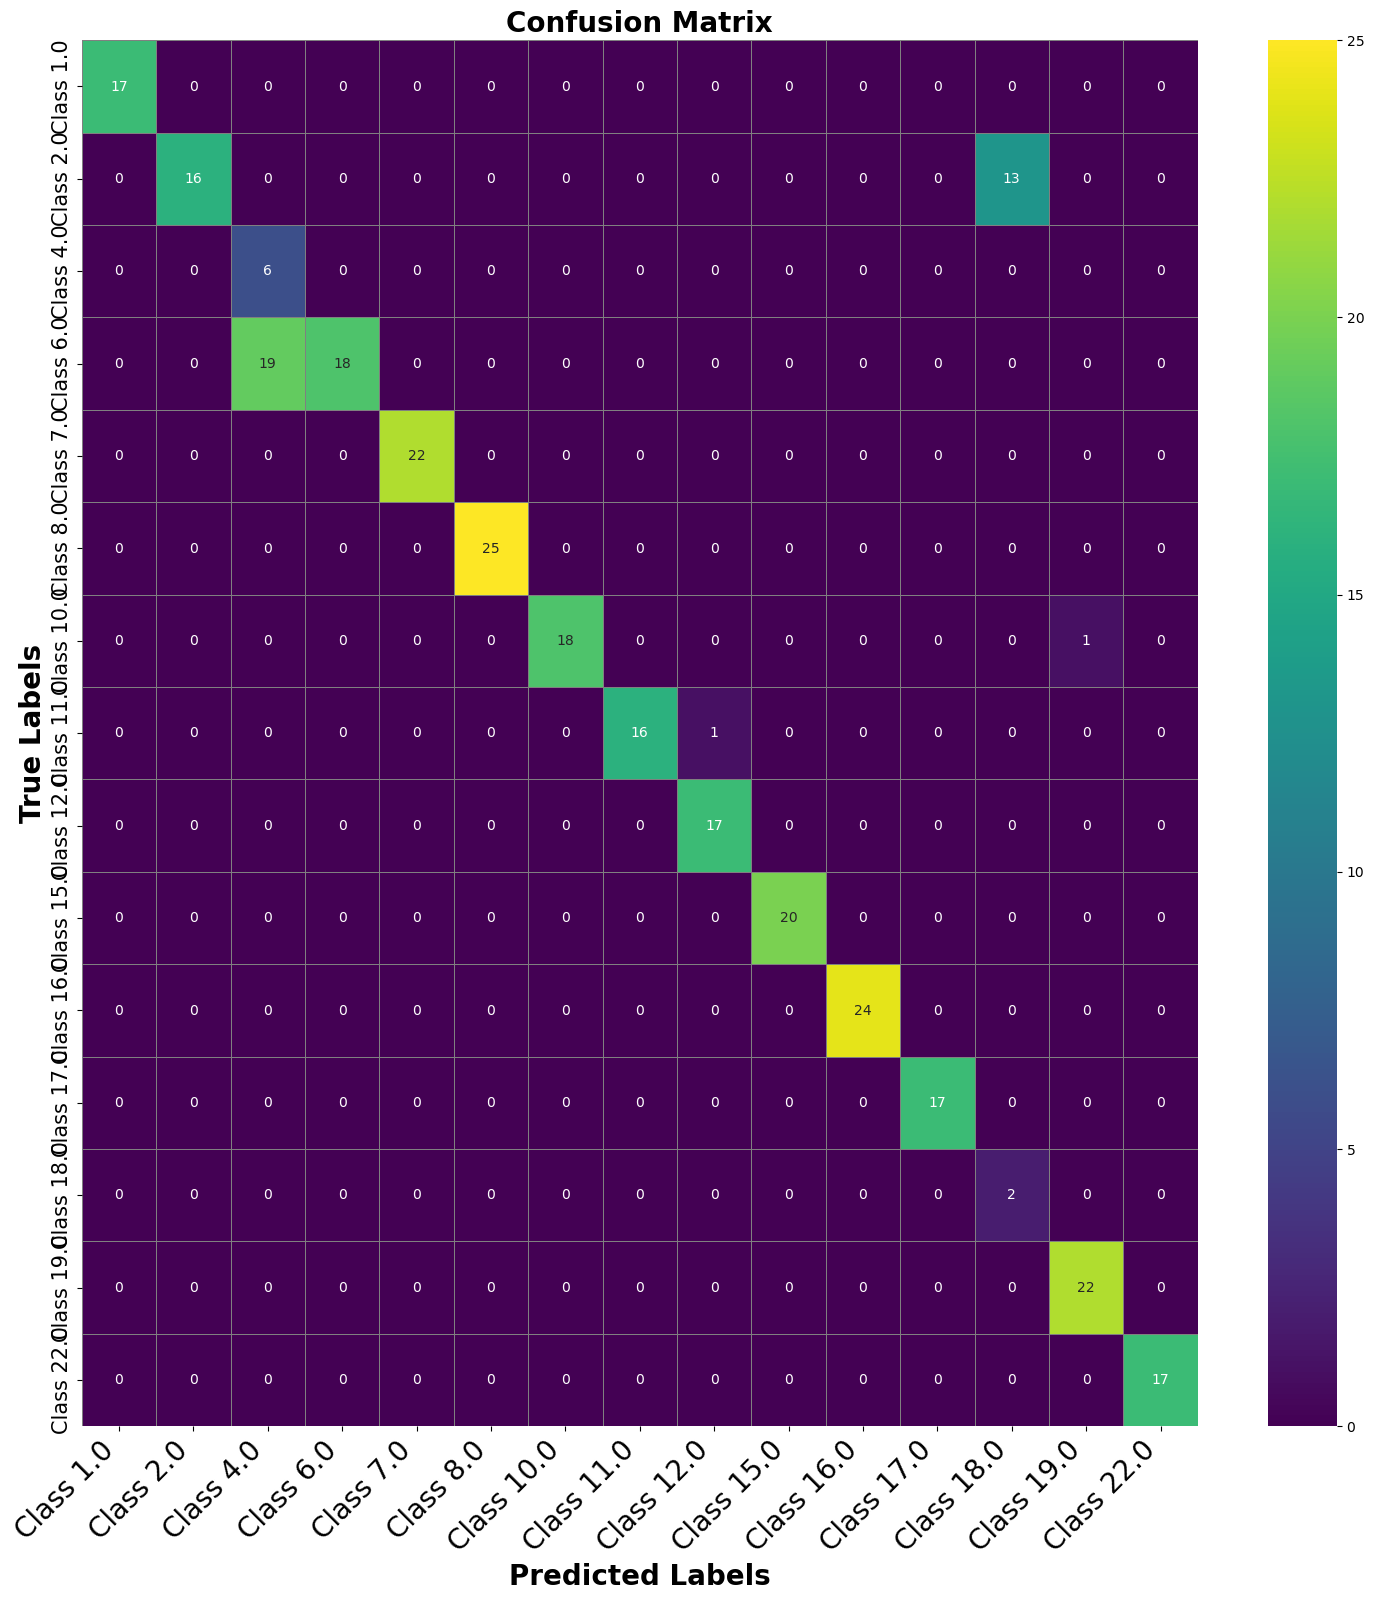


Time taken: 3.0925099849700928


In [22]:
# Decision Trees

start = time.time()

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, dt])
dt_Model = pipeline.fit(trainData)
dt_Predictions = dt_Model.transform(testData)

display(HTML('<h1 style="color:blue;">Decision Trees Results</h1>'))

dt_accuracy = evaluate_and_show_results(dt_Predictions, "Random Forests")

# Confusion Matrix
plot_confusion_matrix(dt_Predictions, plot_title="Decision Trees Results in Confusion Matrix")

elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


# Random Forests

Test Accuracy = 0.9684
Test F1 Score = 0.9681
Test Weighted Precision = 0.9695
Test Weighted Recall = 0.9684


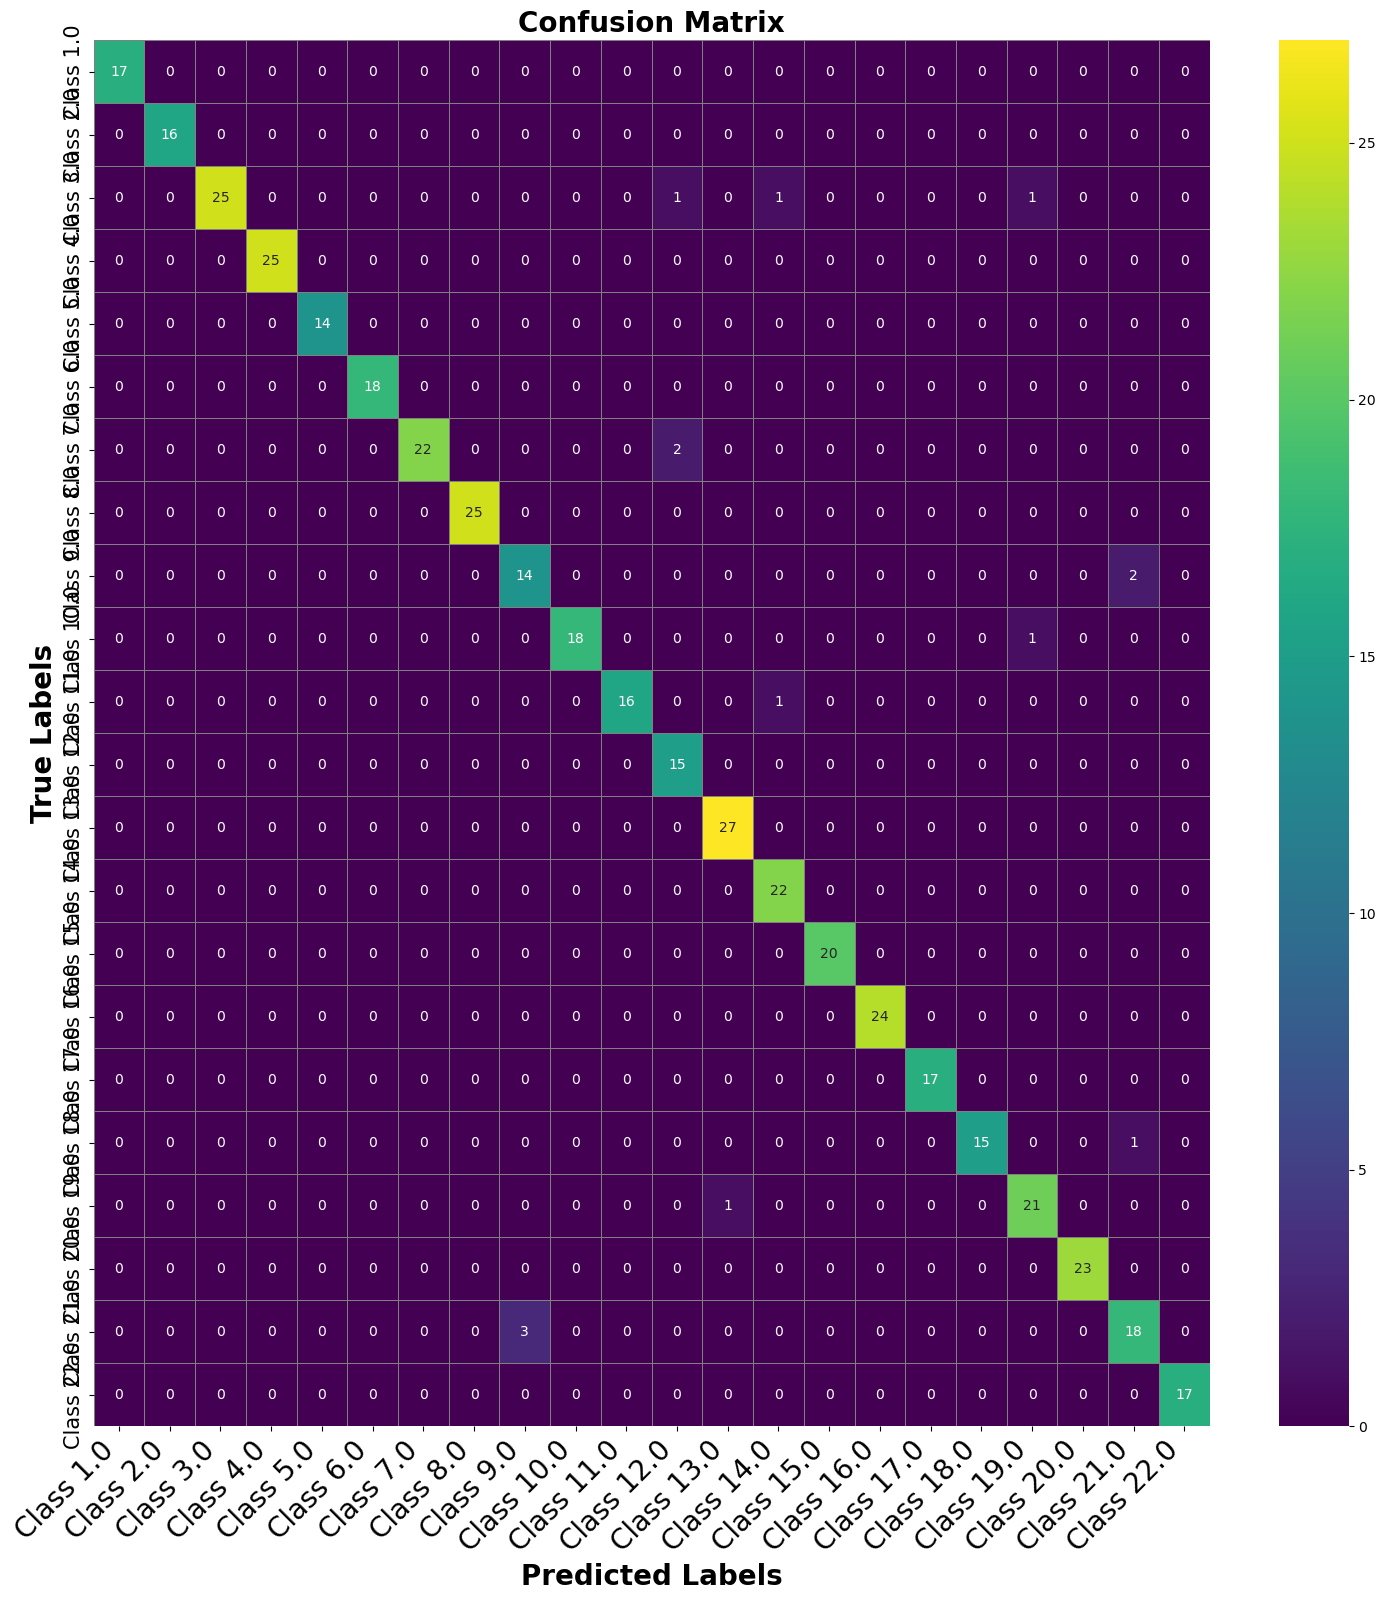


Time taken: 2.531528949737549


In [23]:
# Random Forests

start = time.time()

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])
model = pipeline.fit(trainData)
rf_predictions = model.transform(testData)


display(HTML('<h1 style="color:blue;">Random Forests Results</h1>'))

rf_accuracy = evaluate_and_show_results(rf_predictions, "Random Forests")

 
# Confusion Matrix
plot_confusion_matrix(rf_predictions, plot_title="Random Forests Results in Confusion Matrix")

elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


# Logistic Regression

24/04/02 18:33:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Test Accuracy = 0.9842
Test F1 Score = 0.9842
Test Weighted Precision = 0.985
Test Weighted Recall = 0.9842


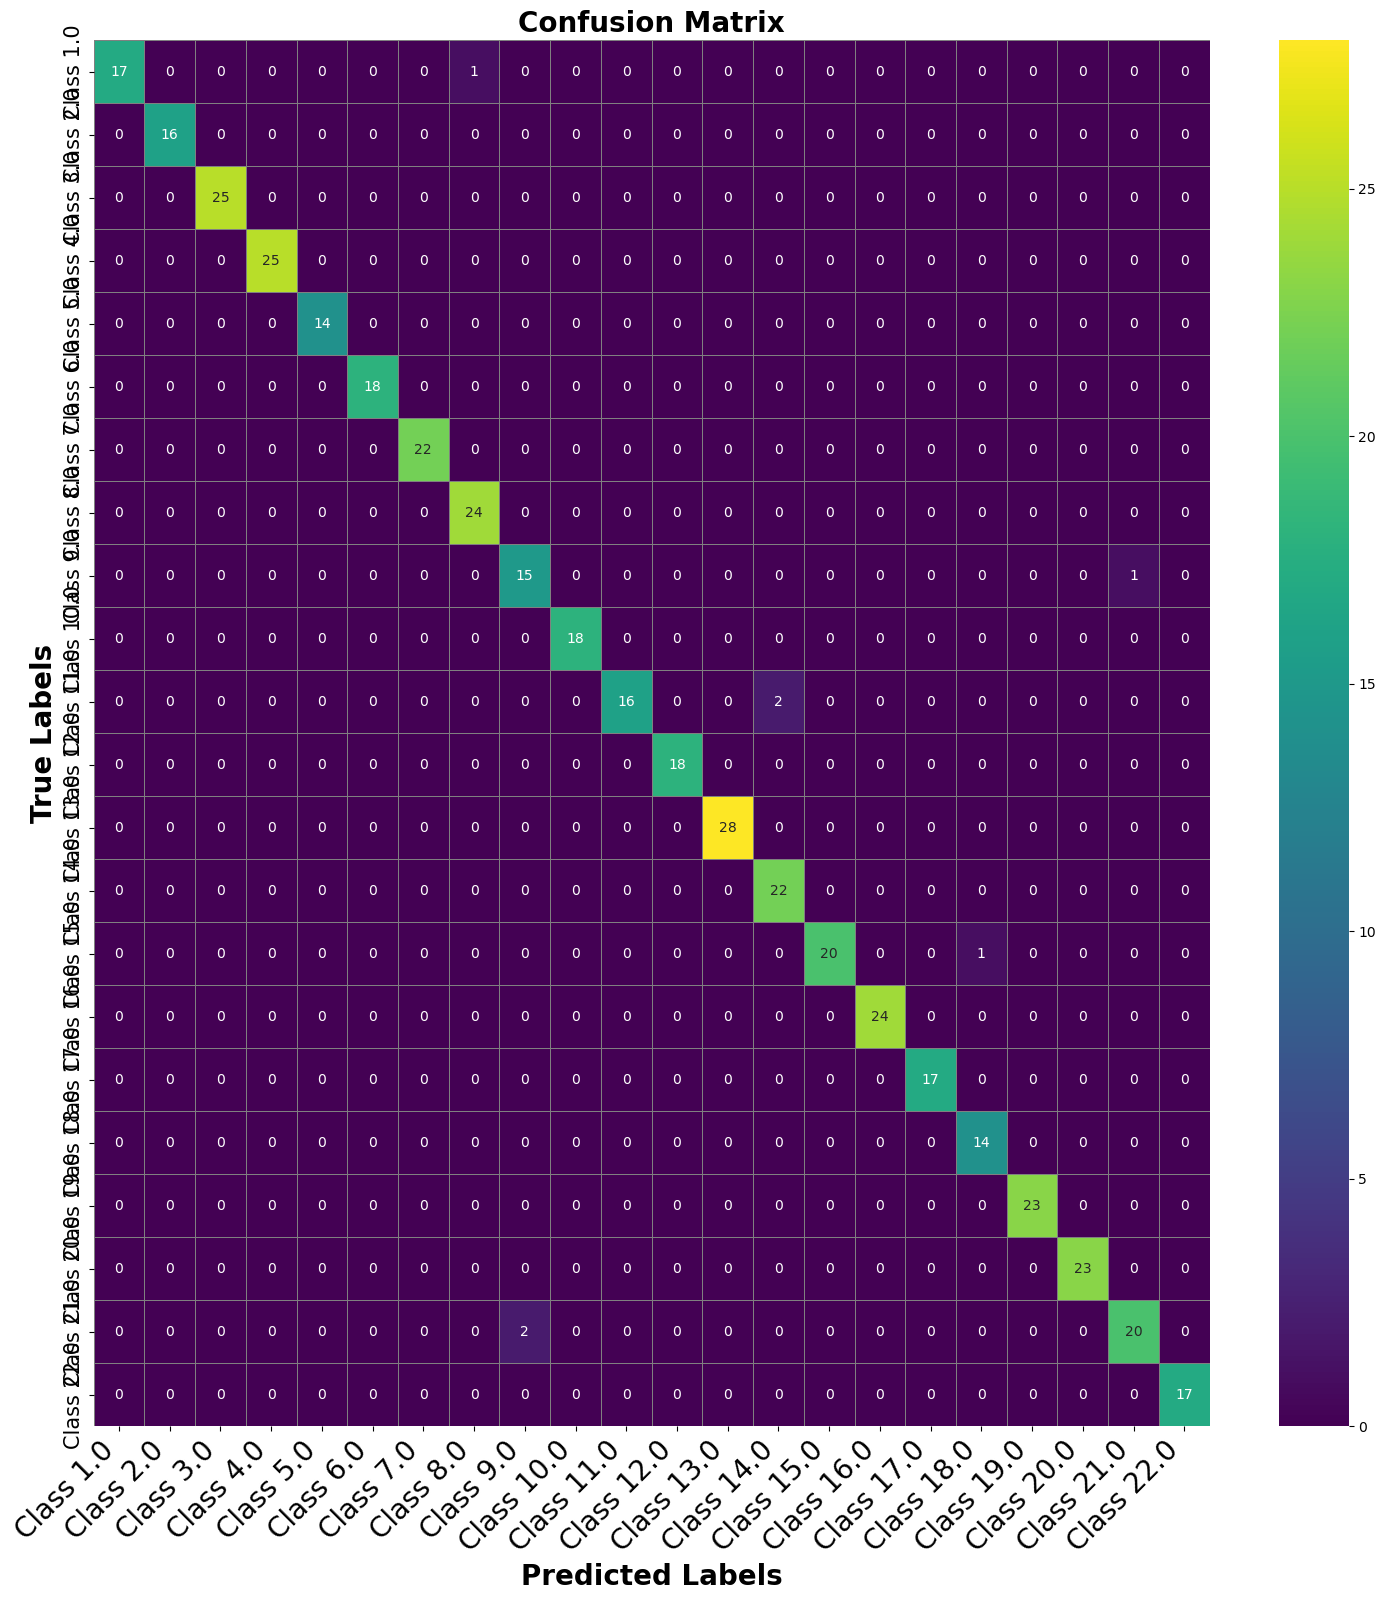


Time taken: 7.088361978530884


In [24]:
# Logistic Regression

start = time.time()

lr = LogisticRegression(labelCol="label", featuresCol="features", family="multinomial")
pipeline = Pipeline(stages=[labelIndexer, assembler, lr])
model = pipeline.fit(trainData)
lr_predictions = model.transform(testData)


display(HTML('<h1 style="color:blue;">Logistic Regression Results</h1>'))

lr_accuracy = evaluate_and_show_results(lr_predictions, "Logistic Regression")


# Confusion Matrix
plot_confusion_matrix(lr_predictions, plot_title="Logistic Regression Results in Confusion Matrix")


elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


# Naive Bayes

Test Accuracy = 0.8871
Test F1 Score = 0.8861
Test Weighted Precision = 0.8915
Test Weighted Recall = 0.8871


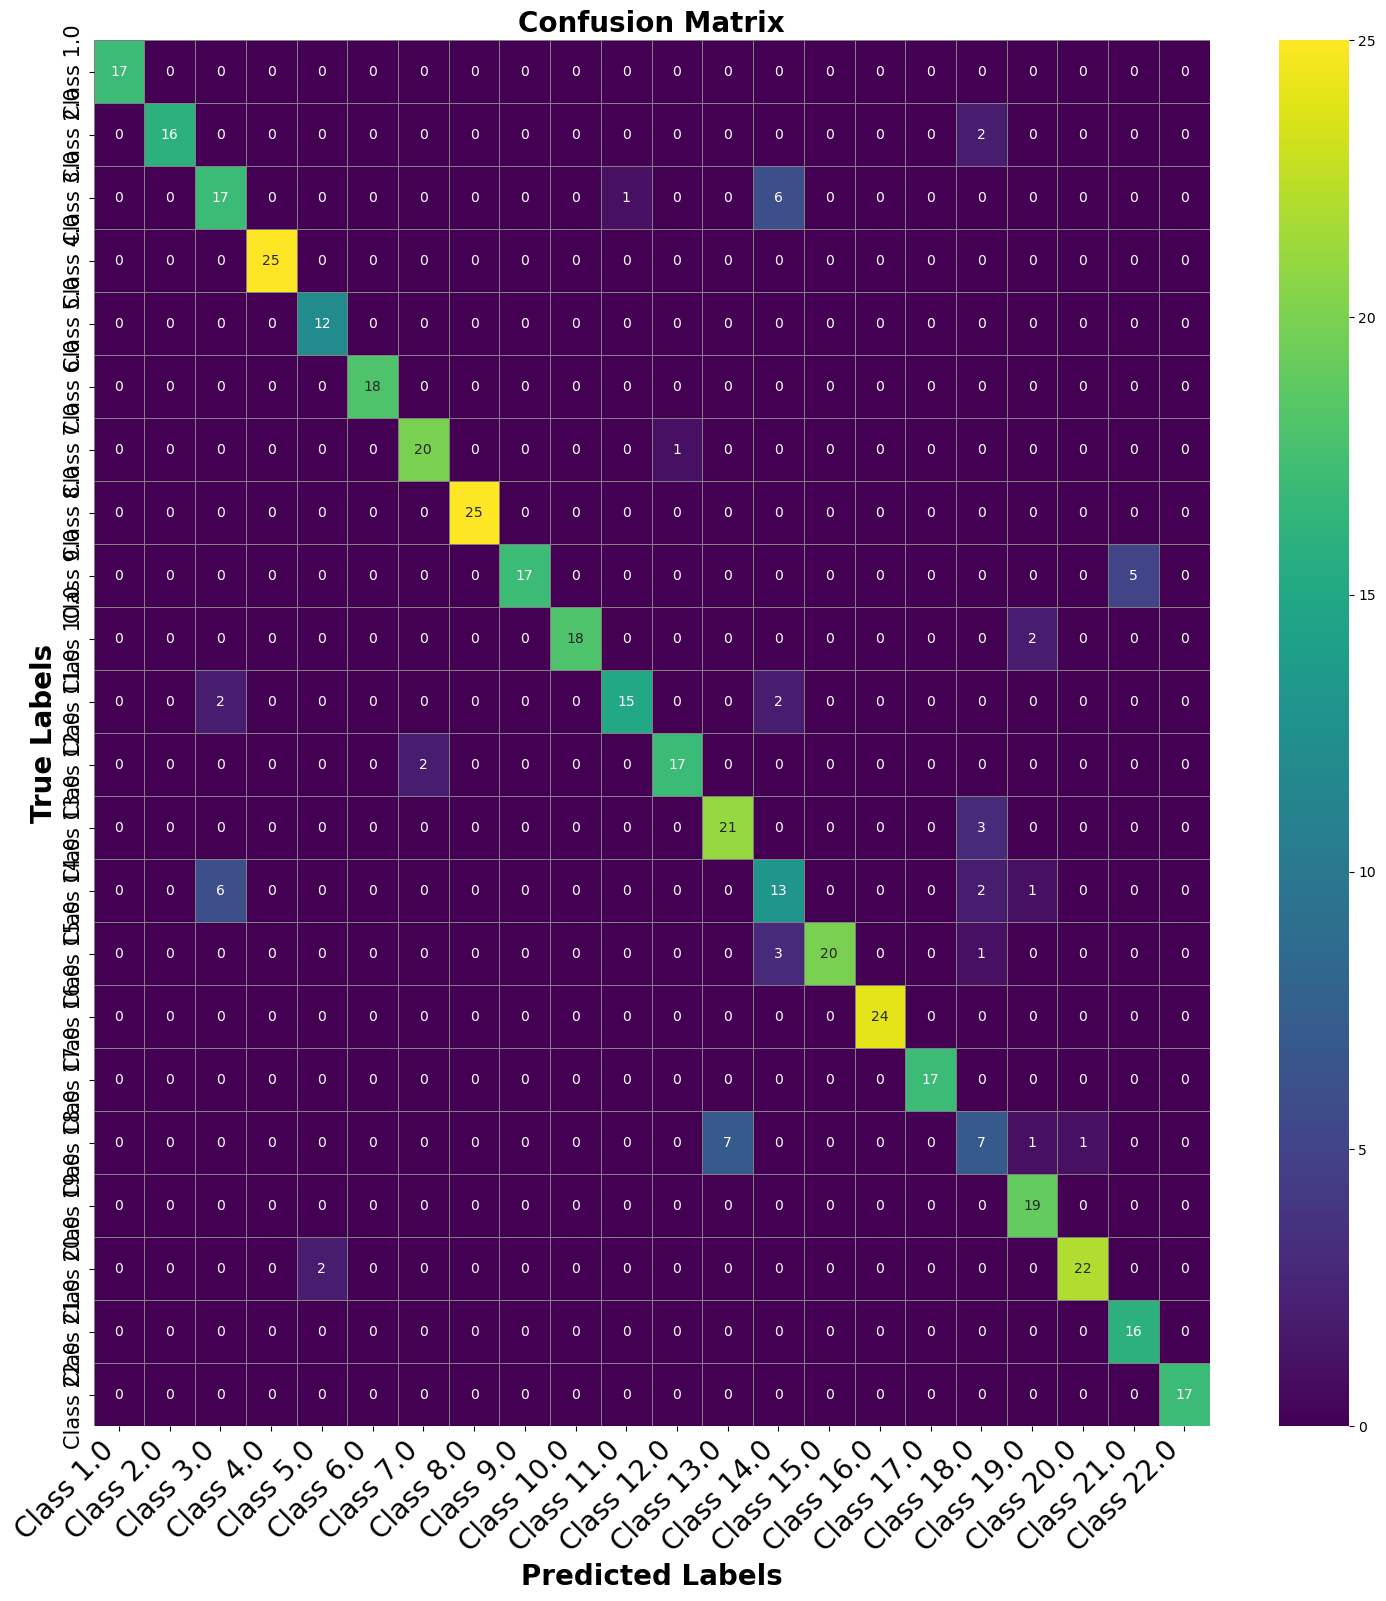


Time taken: 2.2189719676971436


In [25]:
# Naive Bayes
start = time.time()

nb = NaiveBayes(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, nb])
model = pipeline.fit(trainData)
nb_predictions = model.transform(testData)

display(HTML('<h1 style="color:blue;">Naive Bayes Results</h1>'))

nb_accuracy = evaluate_and_show_results(nb_predictions, "Naive Bayes")

# Confusion Matrix
plot_confusion_matrix(nb_predictions, plot_title="Naive Bayes in Confusion Matrix")


elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


# Model Comparison

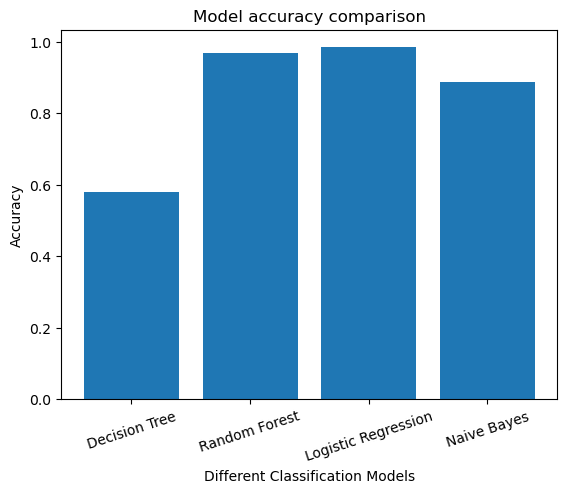

In [26]:
models = ['Decision Tree','Random Forest','Logistic Regression','Naive Bayes']
acc = [dt_accuracy, rf_accuracy, lr_accuracy, nb_accuracy]
# creating the bar plot
plt.bar(models, acc, width = 0.8)
 
plt.xlabel("Different Classification Models")
plt.ylabel("Accuracy")
plt.title("Model accuracy comparison")
plt.xticks(rotation=18)
plt.show()


# Cross-Validation for All Models

Test Accuracy = 0.9797
Test F1 Score = 0.9796
Test Weighted Precision = 0.9804
Test Weighted Recall = 0.9797


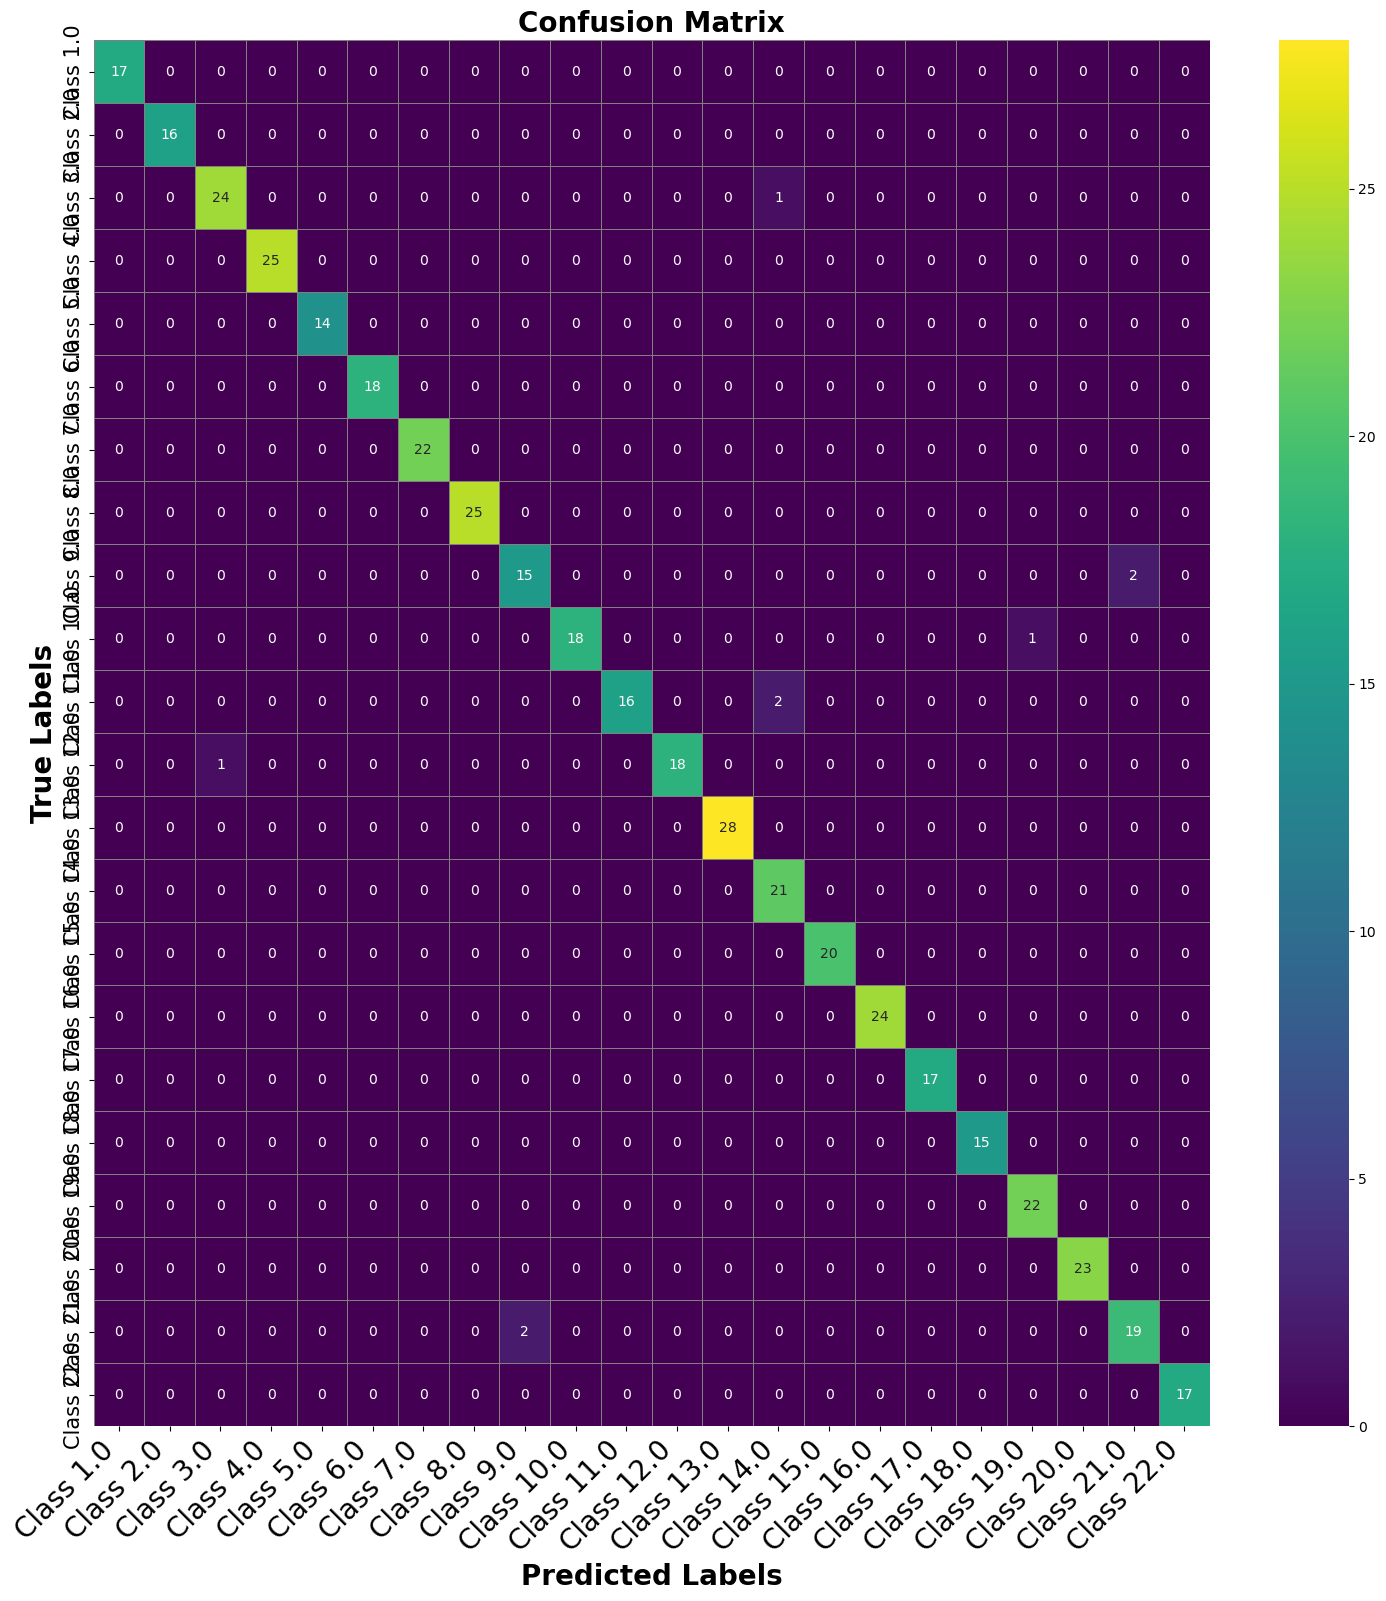


Time taken: 23.509256839752197


In [27]:
# DecisionTree Cross-Validation
start = time.time()

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, dt])

#Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10, 20]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()

# Define cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=5)  # Use 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(trainData)

# Make predictions on the test data
cvPredictions = cvModel.transform(testData)

display(HTML('<h1 style="color:blue;">DecisionTree Cross-Validation Results</h1>'))

dt_cv_accuracy = evaluate_and_show_results(cvPredictions, "Cross-Validation predictions")


# Confusion Matrix
plot_confusion_matrix(cvPredictions, plot_title="DecisionTree Cross-Validation Results in Confusion Matrix")

elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


Test Accuracy = 0.9752
Test F1 Score = 0.9749
Test Weighted Precision = 0.9782
Test Weighted Recall = 0.9752


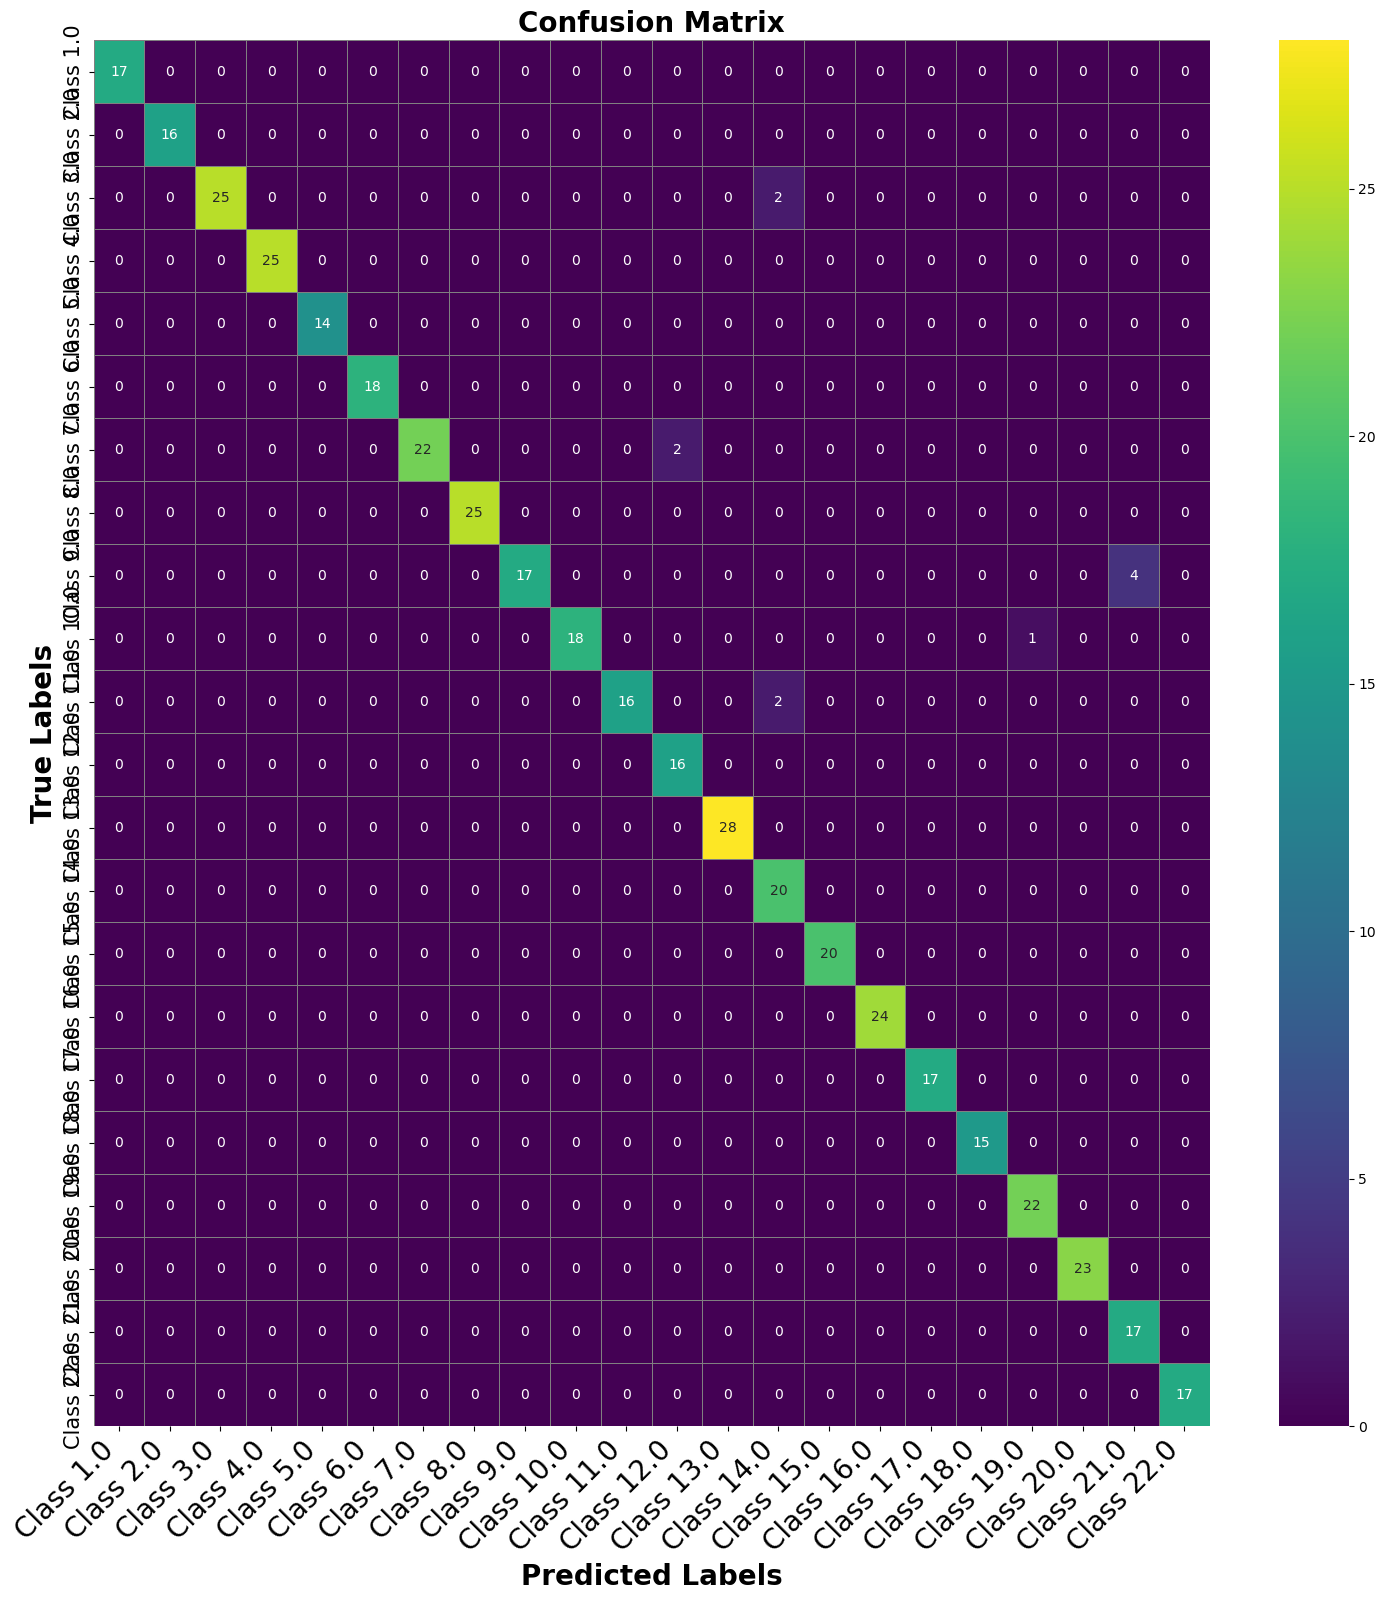


Time taken: 12.541737079620361


In [28]:
# Random Forests Cross-Validation
start = time.time()

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])


#Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.impurity, ["gini", "entropy"]) \
    .build()


# Define cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=5)  # Use 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(trainData)

# Make predictions on the test data
cvPredictions = cvModel.transform(testData)

display(HTML('<h1 style="color:blue;">Random Forests Cross-Validation Results</h1>'))

rf_cv_accuracy = evaluate_and_show_results(cvPredictions, "Cross-Validation predictions")


# Confusion Matrix
plot_confusion_matrix(cvPredictions, plot_title="Random Forests Cross-Validation Results in Confusion Matrix")

elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


Test Accuracy = 0.9819
Test F1 Score = 0.982
Test Weighted Precision = 0.9834
Test Weighted Recall = 0.9819


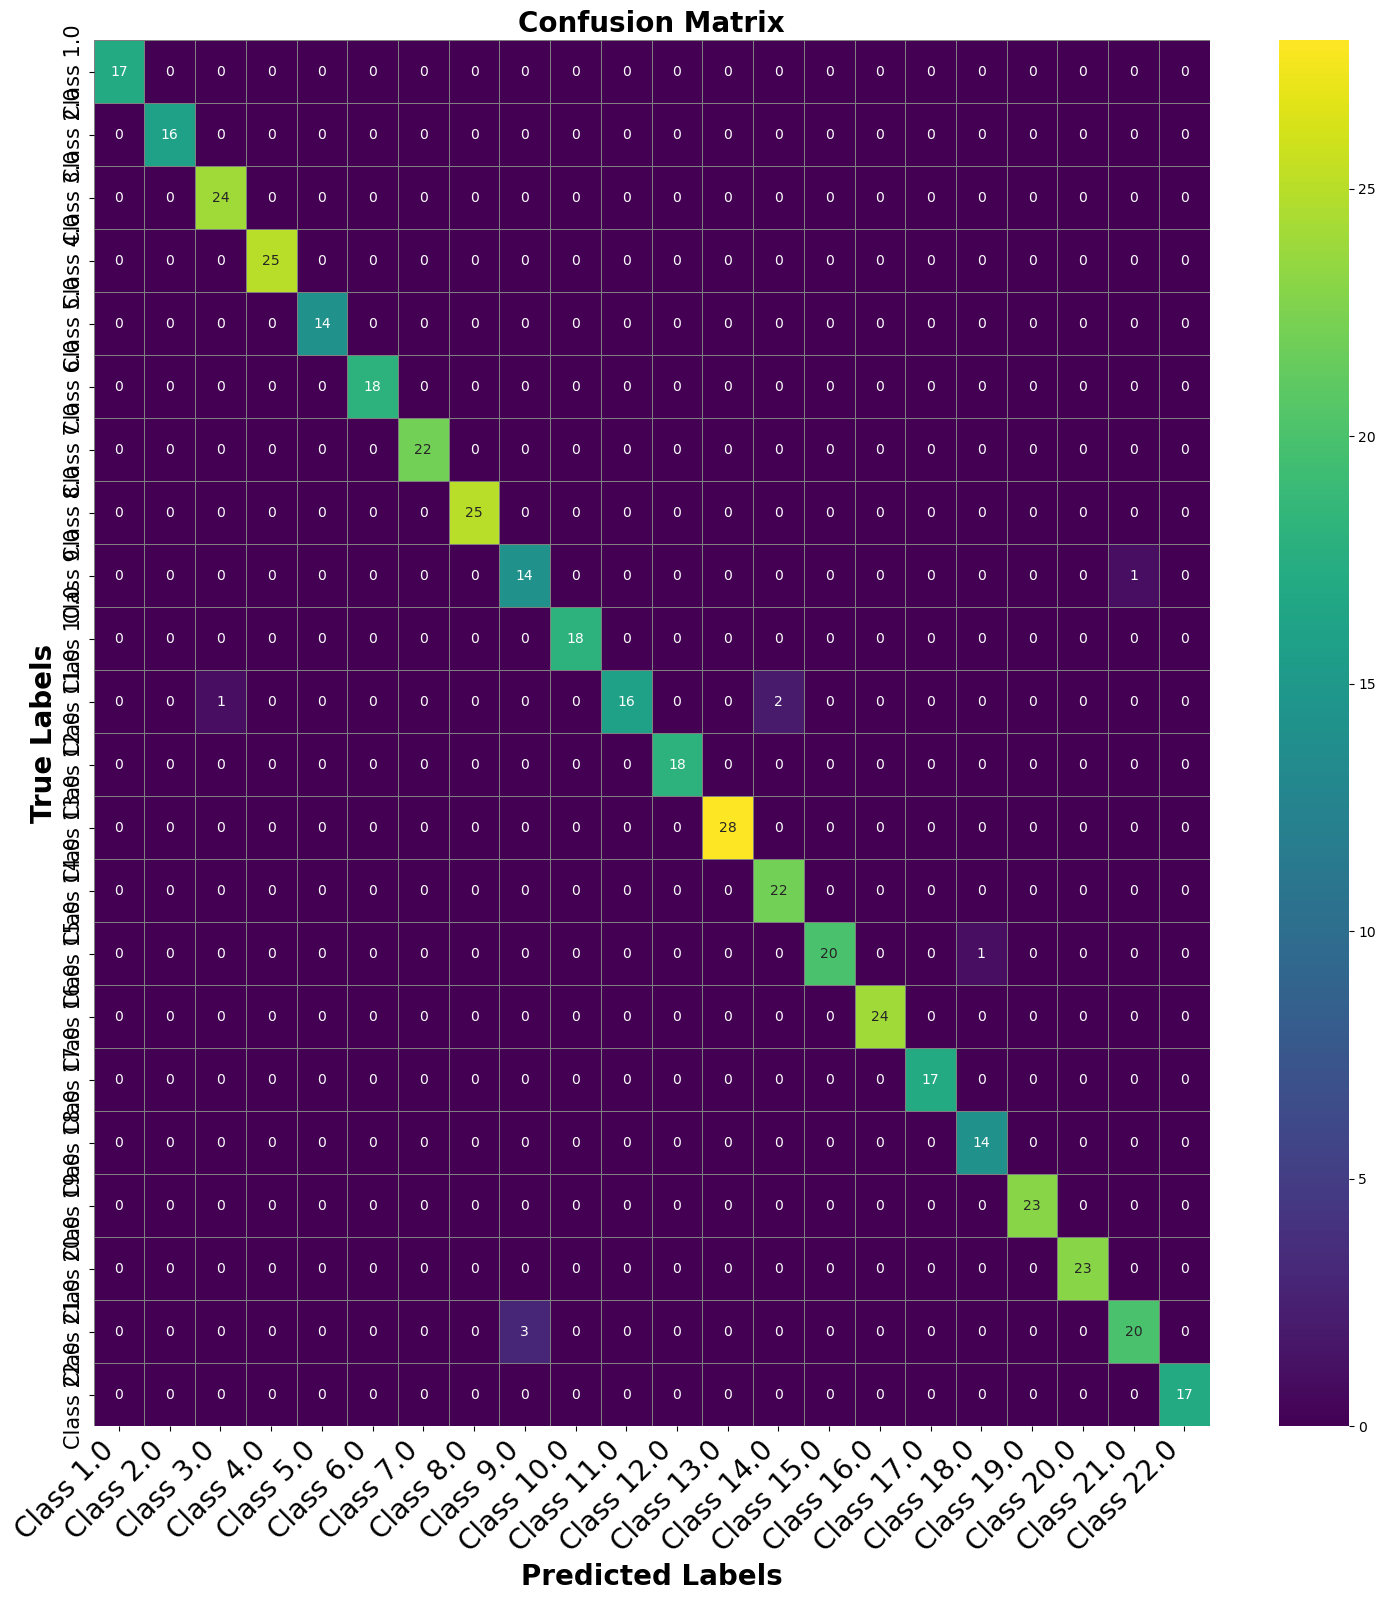


Time taken: 19.661084175109863


In [29]:
# Logistic Regression Cross-Validation

start = time.time()

lr = LogisticRegression(labelCol="label", featuresCol="features", family="multinomial")
pipeline = Pipeline(stages=[labelIndexer, assembler, lr])

#Define parameter grid
paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [10, 50, 100]).build()


# Define cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=5)  # Use 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(trainData)

# Make predictions on the test data
cvPredictions = cvModel.transform(testData)

display(HTML('<h1 style="color:blue;">Logistic Regression Cross-Validation Results</h1>'))

lr_cv_accuracy = evaluate_and_show_results(cvPredictions, "Cross-Validation predictions")


# Confusion Matrix
plot_confusion_matrix(cvPredictions, plot_title="Logistic Regression Cross-Validation Results in Confusion Matrix")

elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


Test Accuracy = 0.8871
Test F1 Score = 0.8861
Test Weighted Precision = 0.8915
Test Weighted Recall = 0.8871


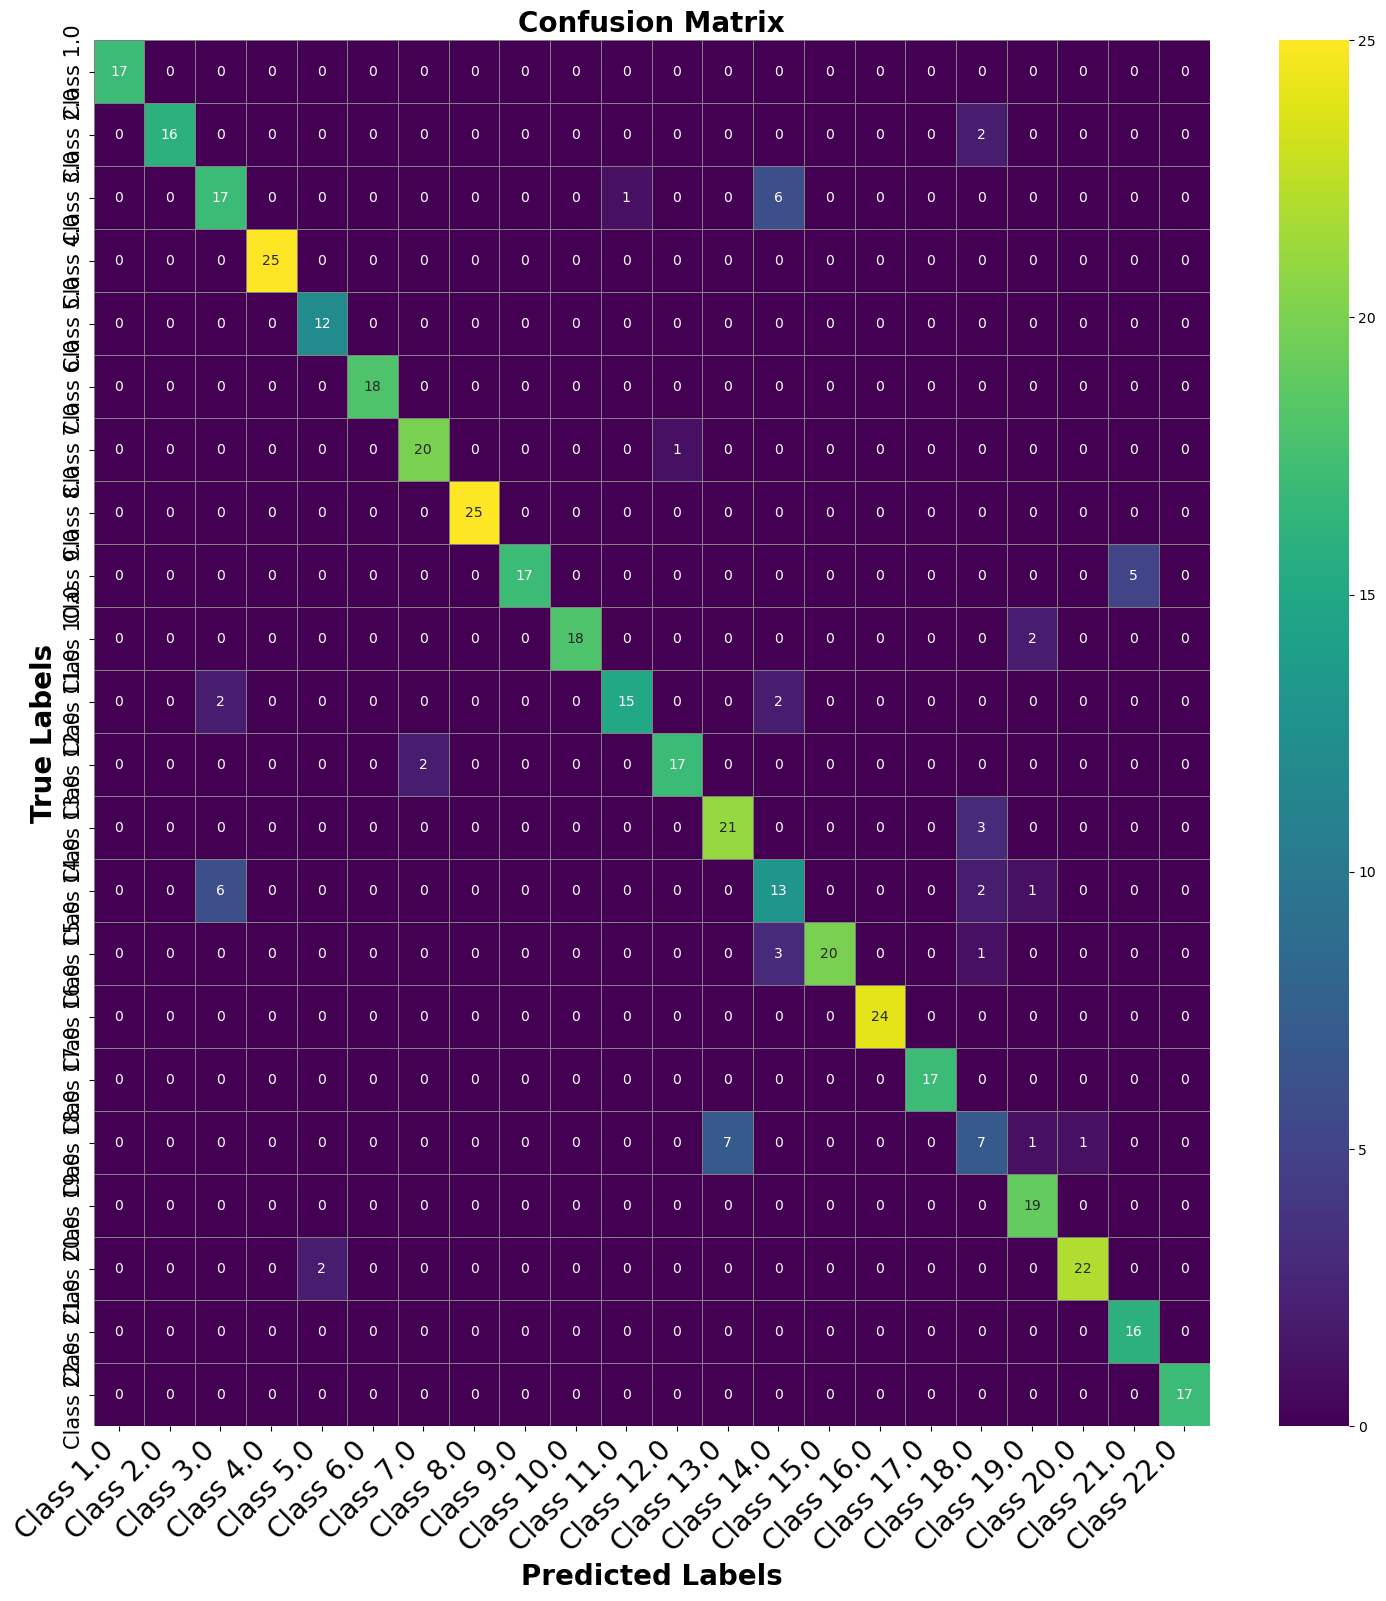


Time taken: 5.25977087020874


In [30]:
# Naive Bayes Cross-Validation

start = time.time()

nb = NaiveBayes(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, assembler, nb])


#Define parameter grid
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.5, 1.0]).build()


# Define cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=5)  # Use 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(trainData)

# Make predictions on the test data
cvPredictions = cvModel.transform(testData)

display(HTML('<h1 style="color:blue;">Naive Bayes Cross-Validation Results</h1>'))

nb_cv_accuracy = evaluate_and_show_results(cvPredictions, "Cross-Validation predictions")


# Confusion Matrix
plot_confusion_matrix(cvPredictions, plot_title="Naive Bayes Cross-Validation Results in Confusion Matrix")

elapsed_time = (time.time()-start)
print("\nTime taken:", elapsed_time)


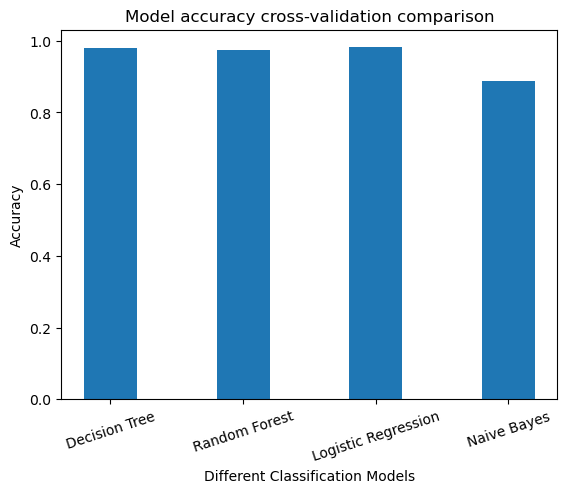

In [31]:
models = ['Decision Tree','Random Forest','Logistic Regression','Naive Bayes']
acc = [dt_cv_accuracy, rf_cv_accuracy, lr_cv_accuracy, nb_cv_accuracy]
# creating the bar plot
plt.bar(models, acc, width = 0.4)
 
plt.xlabel("Different Classification Models")
plt.ylabel("Accuracy")
plt.title("Model accuracy cross-validation comparison")
plt.xticks(rotation=18)
plt.show()


In [32]:
spark.stop()